## Convolutional classifier
This example shows how the convolutional classifiers are built in Tensorflow and how they can be used to classify spectra in the presence of background

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from custom_utils import *

Tune the visual style

In [2]:
matplotlib.style.use("ggplot")
matplotlib.rcParams['figure.figsize'] = (8,6)

Enable memory growth for GPU, it is needed on some systems for convolution to work.

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Read the sample dataset. It contains four classes of Raman spectra. Class labels are available in the last column.

In [4]:
data = pd.read_csv("../spectra.csv.gz").values
features = data[:,:-1] # take everything but last column
labels = data[:,-1] # take last column

Define an auxilary function to generate random polynomials, which will simulate fluorescent background

In [5]:
def random_polynomial(x, a=-1, b=1, order=4):
    x_coords = np.random.uniform(x[0], x[-1], size=order)
    x_coords = np.concatenate([x_coords, [x[0], x[-1]]])
    y_coords = np.random.uniform(a, b, size=order+2)
    coefs = np.polyfit(x_coords, y_coords, deg=order)
    return np.polyval(coefs, x)

And add the background to the spectra

In [6]:
x = np.arange(features.shape[1])
for i in range(features.shape[0]):
    features[i] += random_polynomial(x)

Encode labels in one-hot encoding

In [7]:
labels_oh = to_categorical(labels)

Split the dataset into training and validation (here named test for brevity) subsets.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(features, labels_oh, test_size=0.3)

Plot couple of spectra to check that no error occured. Note that now they have backround.

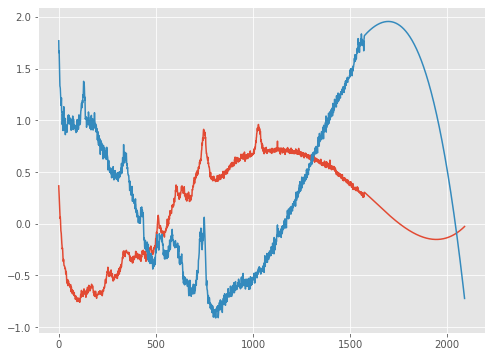

In [9]:
plt.plot(x_train[0])
plt.plot(x_test[0])


Now define important constants

In [10]:
inp_dim = x_train.shape[1]
out_dim = y_train.shape[1]

Firstly we will define classical feed-forward classified (as in previous example)

In [11]:
inp = Input(shape=(inp_dim,))
l = Dense(50, activation="relu")(inp)
l = Dense(25, activation="relu")(l)
out = Dense(out_dim, activation="softmax")(l)

Now create the classifier model, and compile it using crossentropy loss and adam optimizer.

In [12]:
classifier = Model(inp, out)
classifier.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
classifier.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2090)]            0         
_________________________________________________________________
dense (Dense)                (None, 50)                104550    
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 104       
Total params: 105,929
Trainable params: 105,929
Non-trainable params: 0
_________________________________________________________________


Now when we have training and validation datasets and model, we can start training.

In [13]:
train_history = classifier.fit(x=x_train, y=y_train, batch_size=64, epochs=200, validation_data=[x_test, y_test])

Train on 971 samples, validate on 417 samples
Epoch 1/200
971/971 [==============================] - 0s 404us/sample - loss: 4.0988 - accuracy: 0.2606 - val_loss: 4.3253 - val_accuracy: 0.2542
Epoch 2/200
971/971 [==============================] - 0s 44us/sample - loss: 5.1296 - accuracy: 0.2925 - val_loss: 4.9261 - val_accuracy: 0.2734
Epoch 3/200
971/971 [==============================] - 0s 44us/sample - loss: 3.8174 - accuracy: 0.3234 - val_loss: 9.3577 - val_accuracy: 0.2806
Epoch 4/200
971/971 [==============================] - 0s 43us/sample - loss: 4.8137 - accuracy: 0.2853 - val_loss: 6.3676 - val_accuracy: 0.2782
Epoch 5/200
971/971 [==============================] - 0s 42us/sample - loss: 3.7426 - accuracy: 0.2997 - val_loss: 7.3249 - val_accuracy: 0.3501
Epoch 6/200
971/971 [==============================] - 0s 42us/sample - loss: 4.5670 - accuracy: 0.3316 - val_loss: 4.9423 - val_accuracy: 0.2806
Epoch 7/200
971/971 [==============================] - 0s 42us/sample - loss:

Epoch 112/200
971/971 [==============================] - 0s 43us/sample - loss: 0.8012 - accuracy: 0.7817 - val_loss: 1.5402 - val_accuracy: 0.7242
Epoch 113/200
971/971 [==============================] - 0s 44us/sample - loss: 0.7548 - accuracy: 0.7786 - val_loss: 0.7350 - val_accuracy: 0.7362
Epoch 114/200
971/971 [==============================] - 0s 42us/sample - loss: 0.6499 - accuracy: 0.7920 - val_loss: 0.7468 - val_accuracy: 0.7146
Epoch 115/200
971/971 [==============================] - 0s 43us/sample - loss: 0.5830 - accuracy: 0.8136 - val_loss: 0.8094 - val_accuracy: 0.7674
Epoch 116/200
971/971 [==============================] - 0s 43us/sample - loss: 0.5595 - accuracy: 0.8198 - val_loss: 1.3320 - val_accuracy: 0.7698
Epoch 117/200
971/971 [==============================] - 0s 44us/sample - loss: 0.5210 - accuracy: 0.8352 - val_loss: 0.9271 - val_accuracy: 0.7434
Epoch 118/200
971/971 [==============================] - 0s 43us/sample - loss: 0.4760 - accuracy: 0.8527 - val_

Feed-forward classifier has significant difficulties with classifying spectra with background. Draw the loss curves

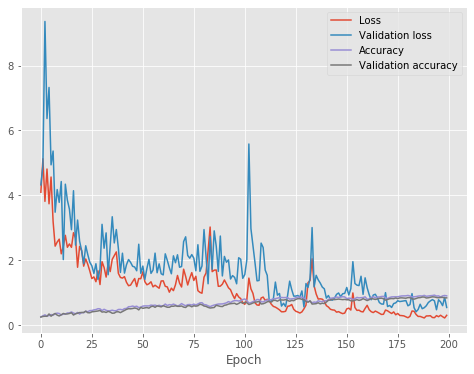

In [14]:
plt.plot(train_history.history['loss'], label="Loss")
plt.plot(train_history.history['val_loss'], label="Validation loss")
plt.plot(train_history.history['accuracy'], label="Accuracy")
plt.plot(train_history.history['val_accuracy'], label="Validation accuracy")
plt.xlabel("Epoch")
plt.legend()

Now add convolutional layers to the classifier. General structure is very similar, but now input must be 2-dimensional, i.e. 1 dimension of data, 1 dimension of channels.

In [15]:
inp = Input(shape=(inp_dim, 1))
# Number of output channels, size of kernel
l = Conv1D(1, 20, activation="relu")(inp)
l = Conv1D(1, 40, activation="relu")(l)
l = Conv1D(1, 80, activation="relu")(l)
# after convolutional layers data must be flattened, i.e. 
# converted to 1D vector
l = Flatten()(l)
l = Dense(50, activation="relu")(l)
l = Dense(25, activation="relu")(l)

out = Dense(out_dim, activation="softmax")(l)

In [16]:
conv_classifier = Model(inp, out)
conv_classifier.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
conv_classifier.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2090, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2071, 1)           21        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2032, 1)           41        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1953, 1)           81        
_________________________________________________________________
flatten (Flatten)            (None, 1953)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                97700     
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1275

We now must add one more dimension to the training data (channel dimension). In numpy it is done by simply indexing array with np.newaxis

In [17]:
x_train_chan = x_train[:,:,np.newaxis]
x_test_chan = x_test[:,:,np.newaxis]

And fit it on the same data

In [18]:
train_history = conv_classifier.fit(x=x_train_chan, y=y_train, batch_size=128, epochs=100, validation_data=[x_test_chan, y_test])

Train on 971 samples, validate on 417 samples
Epoch 1/100
971/971 [==============================] - 1s 1ms/sample - loss: 1.3775 - accuracy: 0.3326 - val_loss: 1.3441 - val_accuracy: 0.3453
Epoch 2/100
971/971 [==============================] - 0s 49us/sample - loss: 1.2727 - accuracy: 0.3769 - val_loss: 1.1943 - val_accuracy: 0.4748
Epoch 3/100
971/971 [==============================] - 0s 46us/sample - loss: 1.1752 - accuracy: 0.4985 - val_loss: 1.1231 - val_accuracy: 0.4556
Epoch 4/100
971/971 [==============================] - 0s 47us/sample - loss: 1.1041 - accuracy: 0.4964 - val_loss: 1.0424 - val_accuracy: 0.4820
Epoch 5/100
971/971 [==============================] - 0s 46us/sample - loss: 0.9783 - accuracy: 0.5438 - val_loss: 0.8300 - val_accuracy: 0.7386
Epoch 6/100
971/971 [==============================] - 0s 47us/sample - loss: 0.7705 - accuracy: 0.8136 - val_loss: 0.6819 - val_accuracy: 0.8082
Epoch 7/100
971/971 [==============================] - 0s 46us/sample - loss: 0

This model converges almost 100% accuracy, which is demonstrates advantages of the convolutional classifiers.

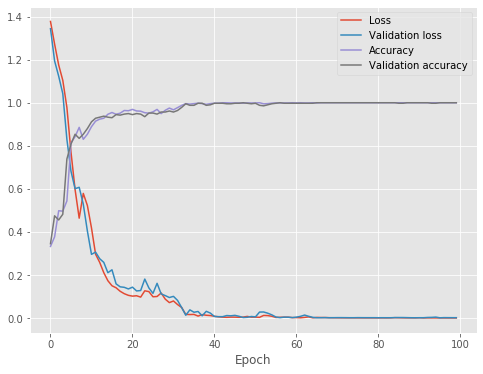

In [19]:
plt.plot(train_history.history['loss'], label="Loss")
plt.plot(train_history.history['val_loss'], label="Validation loss")
plt.plot(train_history.history['accuracy'], label="Accuracy")
plt.plot(train_history.history['val_accuracy'], label="Validation accuracy")
plt.xlabel("Epoch")
plt.legend()

In [ ]:
conv_classifier